# Introduction

Tensor decoupling methods allow use to *decouple* multivariate, vector-valued functions.

More specifically, it allows us to transform a function $\mathbf{f} : \mathbb{R}^{m} \to \mathbb{R}^{n}$ into the following form:
$$\mathbf{W}\mathbf{g}(\mathbf{V}^T\mathbf{x})$$

with $\mathbf{W} \in \mathbb{R}^{n \times r}, \mathbf{V} \in \mathbb{R}^{m \times r}, \mathbf{g}: \mathbb{R}^r \to \mathbb{R}^r$ and $\mathbf{x} \in \mathbb{R}^m$  is the input.

We can see that it consists in two linear transformations with a non linear element-wise transformation in between. We can also easily see that this is equivalent to a 2-layer neural network. https://en.wikipedia.org/wiki/Neural_network_(machine_learning)

Let's show a simple example on how to obtain such a representation using `untangle`.

In [1]:
%%capture
! uv pip install -e ..
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt

Let's begin by defining a simple polynomial function.

In [2]:
def function(x):
    x1, x2 = x
    return jnp.array([
        x1**3 + x1*x2**2 + 2,
        x2**2 - x1 + x2 + 1,
    ])

# example of input/output
x = jnp.array([-0.2, 0.75])
function(x)

Array([1.8795, 2.5125], dtype=float32)

Now, we need to **collect information** about this function.

We can use the utility function `collect_information`, which simply generates random points and returns them alongside with the function outputs, and the stacked jacobian tensor.

In [3]:
from untangle.utils import collect_information

N = 10
X, Y, J = collect_information(function, N, 2, range=(-1, 1))

X.shape, Y.shape, J.shape

((10, 2), (10, 2), (2, 2, 10))

We can now run the decoupling algorithm, but first, we need to decide which **rank** to use as part of the CP decomposition.

Here it's not so expensive to just try many ranks until one yields a very low reconstruction error.

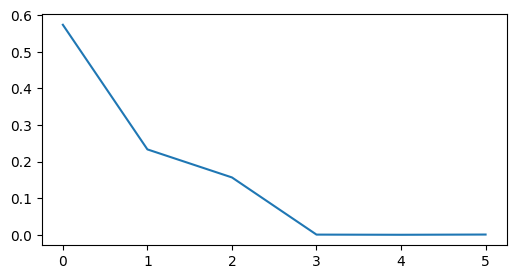

In [4]:
from untangle.decomposition import search_rank

errors = search_rank(J, max_rank=6, stop=False, linesearch=True)

plt.figure(figsize=(6, 2.5))
plt.plot(errors); None

In [5]:
rank = 4

We can finally obtain our decoupled representation.

In [6]:
from untangle.algorithm.basic import decoupling_basic, inference

W, V, coefs = decoupling_basic(X, Y, J, rank, degree=3, linesearch=True)
decoupling = inference(W, V, coefs)

Lets' try it.

In [7]:
function(x), decoupling(x)

(Array([1.8795, 2.5125], dtype=float32),
 Array([1.8964709, 2.5781245], dtype=float32))

In [8]:
x = jnp.array([-0.5, 0.9])
function(x), decoupling(x)

(Array([1.47, 3.21], dtype=float32),
 Array([1.4482571, 3.2006636], dtype=float32))

Let us look at what our internal polynomials look like.

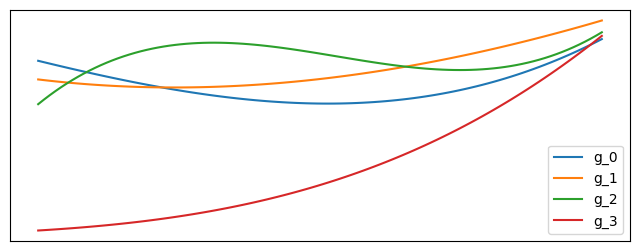

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 3))

x = jnp.linspace(start=-1, stop=1, num=100)
Z = [jnp.polyval(coefs[r], x) for r in range(rank)]
plt.xticks([]); plt.yticks([])
[plt.plot(z, label=f'g_{i}') for i, z in enumerate(Z)]; plt.legend(); None